In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 데이터 수집
ticker = "AAPL" #예: 애플 주식
data = yf.download(ticker, start="2015-01-01", end = "2024-01-01")
data = data[['Close']] #종가만 사용

[*********************100%***********************]  1 of 1 completed


In [5]:
data.head()

Price,Close
Ticker,AAPL
Date,
2015-01-02,24.237549
2015-01-05,23.554737
2015-01-06,23.556961
2015-01-07,23.887278
2015-01-08,24.805088


In [6]:
# 데이터 전처리
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

In [7]:
def create_dataset(dataset, look_back=60):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

In [9]:
look_back = 60 #과거 60일 데이터로 예측
X, y = create_dataset(scaled_data, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # LSTM 입력 형태 (샘플수, 시퀀스 길이, 피처수)

# 모델 구성
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)), #input_shape(시퀀스 길이, 피쳐수)
    LSTM(50),
    Dense(1)
])

c:\code\khj_1pro\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), shuffle=False)

# 예측 및 시각화
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1)) #2차원 배열로 표시(샘플수, 1)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 3.1143e-04 - val_loss: 7.5490e-04
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 6.9833e-04 - val_loss: 0.0025
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 4.2402e-04 - val_loss: 0.0028
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 7.3172e-04 - val_loss: 0.0032
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 8.7182e-04 - val_loss: 0.0019
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0011 - val_loss: 0.0027
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0014 - val_loss: 0.0081
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 5.5483e-04 - val_loss: 0.0010
Epoch 9/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0012 - val_loss: 8.9218e-04
Epoch 10/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 3.5216e-04 - val_loss: 6.5601e-04
Epoch 11/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 6.3484e-04 - val_loss: 6.9445e-04
Epoch 12/20
56/

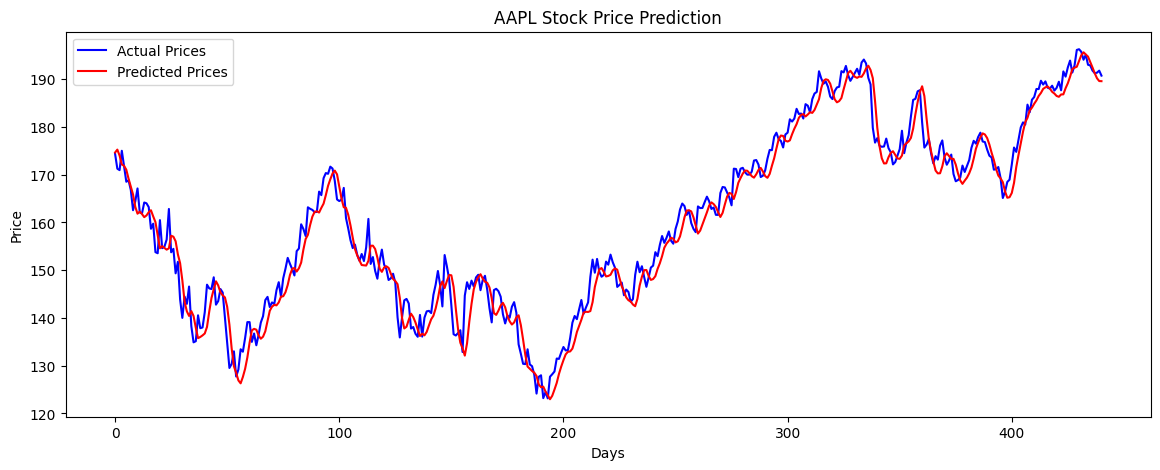

In [19]:
# 실제 값 복원
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# 시각화
plt.figure(figsize=(14, 5))
plt.plot(actual_prices, label="Actual Prices", color='blue')
plt.plot(predictions, label="Predicted Prices", color='red')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()